# Masked Language Modeling

In this lab, we will overview the **masked language modeling** objective, and a popular model architecture called the **Transformer** used for large-scale masked language modeling.


In [1]:
%pylab inline
import os, sys, glob, json, math
import pandas as pd
from tqdm import tqdm
from pprint import pprint
from collections import defaultdict
import torch
import torch.nn as nn

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_colwidth', -1)

Populating the interactive namespace from numpy and matplotlib


## Background

Recently, Devlin et al. published [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf).


**B**idirectional

**E**ncoder

**R**epresentations from

**T**ransformers


#### Goal: 
1. **pre-train** a model that produces language representations, and get good representations of words. (*this week's lab*)
2. **fine-tune** the model on a task, like Question Answering, Natural Language Inference. (*next week's lab*)
    


## Masked Language Model Objective

Randomly mask some of the tokens from the input, predict original vocabulary id of each masked token.

- Given sequence $x_1,\ldots,x_N$.

- Form **mask** $m_1,\ldots,m_N$ where $m_i\in \{0,1\}$.
    - E.g. $m_i=1$ with probability 0.15 (百分之15的tokens会被masked)
    
- Form **masked sequence** $\tilde{x}_1,\ldots,\tilde{x}_N$.
    - $\tilde{x}_i=\begin{cases} x_i & m_i=0\\ \texttt{[MASK]} & m_i=1\end{cases}$


The objective we're going to train the model with：

#### $$\mathcal{L}_{\text{MLM}}=-\sum_{\underbrace{i | m_i=1}_{\text{MASKED POSITIONS}}}\log p_{\theta}(\underbrace{x_i}_{\text{TRUE TOKEN}}|\underbrace{\tilde{x}_1,\ldots, \tilde{x}_{i-1}, \tilde{x}_{i+1},\ldots, \tilde{x}_N}_{\text{MASKED SEQUENCE}})$$


<!-- Below, we will discuss the exact form of $\tilde{x}_i$ that the BERT authors used. -->


<!-- #### Diagram of BERT Implementation -->
<!-- ![](bert_overview.png) -->

## Transformers

So far we have modeled a sequence by factorizing the joint distribution into conditionals, and **parameterizing each conditional with a recurrent network**:


#### $$p_{\theta}(x_1,\ldots,x_T)=\prod_{t=1}^T p_{\theta}(x_t | x_{<t})$$
\begin{align}
h_t &= RNN(x_{t}, h_{t-1})\\
p_{\theta}(x_t | x_{<t}) &=\text{softmax}\left(Wh_t+b\right),
\end{align}

where $\theta$ are the model parameters (RNN parameters, $W, b$, embedding matrix).


#### Alternative

An alternative proposed in [[Vaswani et al 2017](https://arxiv.org/pdf/1706.03762.pdf)] is to parameterize each conditional with a **particular feed-forward architecture** called the **Transformer**. With this model, it is possible to compute all conditionals with a **single feed-forward pass**:
\begin{align}
(h_1,\ldots,h_T) &= Transformer(x)\\
p_{\theta}(x_t | x_{<t}) &= \text{softmax}\left(Wh_t + b\right)
\end{align}

We will discuss briefly the key ideas, the overall Transformer architecture (encoder only), and how they are used in Pytorch.

### High-Level View

We can view the Transformer encoder as mapping a sequence to a sequence of vectors.

<img src="img/high1.png" alt="Drawing" style="width: 35%;"/>

Let's step through the key ideas of how this mapping is designed, and discuss some of its resulting properties.

### Key Idea 1: Position Embeddings

Unlike RNNs which can learn positional information via the hidden state over time, the Transformer has no notion of time (**similar to the bag-of-words model you implemented**).

Thus we encode inputs with **position** as well as **token** embeddings:

<img src="img/high2.png" alt="Drawing" style="width: 35%;"/>

In the original paper they have more complicated way to do positional embedding. Here is a very simple example.

In [2]:
input_sequence = ['<s>', 'my', 'pet', '[M]', '<s>']

max_len = 10 # 句子长度为10

vocab = {'<s>': 0, 'my': 1, 'pet': 2, 'dog': 3, 'cat': 4, 'lion': 5, '[M]': 6} # 所有词汇 7个

dim = 6 # embedding dimension

token_embed = nn.Embedding(len(vocab), embedding_dim=dim) # 对每个word，给一个embedding
position_embed = nn.Embedding(max_len, embedding_dim=dim) # 对每个可能的index 0-9 因为句子最长为10，给一个embedding

In [3]:
input_vector = torch.tensor([vocab[x] for x in input_sequence]).unsqueeze(1) # torch.Size([5, 1])
# .unsqueeze(1) 把
# tensor([0, 1, 2, 6, 0])
# 变成
# tensor([[0],
#         [1],
#         [2],
#         [6],
#         [0]])

In [4]:
pos_vector = torch.arange(len(input_vector)).unsqueeze(1) # torch.Size([5, 1, 6])

In [5]:
input_embeddings = token_embed(input_vector) + position_embed(pos_vector) # torch.Size([5, 1, 6])

**Warning!!** The pytorch Transformer classes accept input as `Length x Batch x Dim`

#### Key Idea 2: Modularity
The Transformer (encoder) is composed of a stack of **N identical layers**.

<img src="img/layers.png" alt="Drawing" style="width: 35%;"/>

In [6]:
import torch.nn as nn
nn.TransformerEncoder?

Init signature: nn.TransformerEncoder(encoder_layer, num_layers, norm=None)
Docstring:     
TransformerEncoder is a stack of N encoder layers

Args:
    encoder_layer: an instance of the TransformerEncoderLayer() class (required).
    num_layers: the number of sub-encoder-layers in the encoder (required).
    norm: the layer normalization component (optional).

Examples::
    >>> encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
    >>> transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
    >>> src = torch.rand(10, 32, 512)
    >>> out = transformer_encoder(src)
Init docstring: Initializes internal Module state, shared by both nn.Module and ScriptModule.
File:           /anaconda3/lib/python3.7/site-packages/torch/nn/modules/transformer.py
Type:           type
Subclasses:     


#### The `forward` passes the input through the N layers, then normalizes it:

**Warning!!** The forward function accepts input as `Length x Batch x Dim`

In [7]:
nn.TransformerEncoder.forward??

Signature:
nn.TransformerEncoder.forward(
    self,
    src,
    mask=None,
    src_key_padding_mask=None,
)
Source:   
    def forward(self, src, mask=None, src_key_padding_mask=None):
        r"""Pass the input through the encoder layers in turn.

        Args:
            src: the sequnce to the encoder (required).
            mask: the mask for the src sequence (optional).
            src_key_padding_mask: the mask for the src keys per batch (optional).

        Shape:
            see the docs in Transformer class.
        """
        output = src

        for i in range(self.num_layers):
            output = self.layers[i](output, src_mask=mask,
                                    src_key_padding_mask=src_key_padding_mask)

        if self.norm:
            output = self.norm(output)

        return output
File:      /anaconda3/lib/python3.7/site-packages/torch/nn/modules/transformer.py
Type:      function


In [8]:
nn.TransformerEncoderLayer?

Init signature:
nn.TransformerEncoderLayer(
    d_model,
    nhead,
    dim_feedforward=2048,
    dropout=0.1,
    activation='relu',
)
Docstring:     
TransformerEncoderLayer is made up of self-attn and feedforward network.
This standard encoder layer is based on the paper "Attention Is All You Need".
Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
in a different way during application.

Args:
    d_model: the number of expected features in the input (required).
    nhead: the number of heads in the multiheadattention models (required).
    dim_feedforward: the dimension of the feedforward network model (default=2048).
    dropout: the dropout value (default=0.1).
    activation: the activation function of intermediate layer, relu or gelu (default=relu).

Examples::
    >>> enc

In [9]:
encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=2, dim_feedforward=64, dropout=0.1)

encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)

In [10]:
outputs = encoder(input_embeddings)

print("input size: \t%s" % str(tuple(input_embeddings.shape)))
print("output size:\t%s" % str(tuple(outputs.shape)))
outputs

input size: 	(5, 1, 6)
output size:	(5, 1, 6)


tensor([[[ 0.7153,  0.5646, -1.1680,  1.4957, -0.4325, -1.1751]],

        [[ 0.1150,  1.7427, -0.3667,  0.6743, -0.9921, -1.1732]],

        [[-0.4244,  1.1399, -0.2857,  1.5418, -0.7428, -1.2288]],

        [[ 0.5464,  1.0669, -0.4767,  1.2153, -0.9602, -1.3918]],

        [[ 0.3594,  0.8685,  0.5280,  1.0084, -1.3872, -1.3771]]],
       grad_fn=<NativeLayerNormBackward>)

#### Each layer has two parts, **self-attention** and a feed-forward transformation:

<img src="img/layer.png" alt="Drawing" style="width: 65%;"/>

In [11]:
nn.TransformerEncoderLayer??

Init signature:
nn.TransformerEncoderLayer(
    d_model,
    nhead,
    dim_feedforward=2048,
    dropout=0.1,
    activation='relu',
)
Source:        
class TransformerEncoderLayer(Module):
    r"""TransformerEncoderLayer is made up of self-attn and feedforward network.
    This standard encoder layer is based on the paper "Attention Is All You Need".
    Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez,
    Lukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in
    Neural Information Processing Systems, pages 6000-6010. Users may modify or implement
    in a different way during application.

    Args:
        d_model: the number of expected features in the input (required).
        nhead: the number of heads in the multiheadattention models (required).
        dim_feedforward: the dimension of the feedforward network model (default=2048).
        dropout: the dropout value (default=0.1).
        activation: the acti

### Key Idea 3: Self-Attention

In the RNN, the hidden state contains information about previous tokens.
The Transformer instead performs **attention** over all inputs at a given layer. 'Attention' computes an output vector by taking a weighted sum of input vectors. The weights are 'attention weights'. The Transformer uses **scaled dot-product attention**:
#### $$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

and 'Multi-head Attention' refers to applying several of these operations in parallel.

<img src="img/attention.png" alt="Drawing" style="width: 55%;"/>

Above image is from [Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/).

#### *Key Property*: Each output vector of a layer $n$ can using information from **all** inputs to the layer $n$.

Thus each **final output vector** can incorporate information from **all input words**.

(If we want to prevent information flow such as in left-to-right language modeling, we can use masking).

In [12]:
nn.MultiheadAttention?

Init signature:
nn.MultiheadAttention(
    embed_dim,
    num_heads,
    dropout=0.0,
    bias=True,
    add_bias_kv=False,
    add_zero_attn=False,
    kdim=None,
    vdim=None,
)
Docstring:     
Allows the model to jointly attend to information
from different representation subspaces.
See reference: Attention Is All You Need

.. math::
    \text{MultiHead}(Q, K, V) = \text{Concat}(head_1,\dots,head_h)W^O
    \text{where} head_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)

Args:
    embed_dim: total dimension of the model.
    num_heads: parallel attention heads.
    dropout: a Dropout layer on attn_output_weights. Default: 0.0.
    bias: add bias as module parameter. Default: True.
    add_bias_kv: add bias to the key and value sequences at dim=0.
    add_zero_attn: add a new batch of zeros to the key and
                   value sequences at dim=1.
    kdim: total number of features in key. Default: None.
    vdim: total number of features in key. Default: None.

    Note: if kdim an

In [13]:
attn = nn.MultiheadAttention(dim, 2, dropout=0.0)  # 2是parallel attention heads

attn_outputs, attn_weights = attn.forward(query=outputs, key=outputs, value=outputs)

print("input shape: %s" % (str(tuple(outputs.size()))))
print("output shape: %s" % (str(tuple(attn_outputs.size()))))
print(outputs)

print("\nattn weights shape: %s" % (str(tuple(attn_weights.size()))))
print(attn_weights)

input shape: (5, 1, 6)
output shape: (5, 1, 6)
tensor([[[ 0.7153,  0.5646, -1.1680,  1.4957, -0.4325, -1.1751]],

        [[ 0.1150,  1.7427, -0.3667,  0.6743, -0.9921, -1.1732]],

        [[-0.4244,  1.1399, -0.2857,  1.5418, -0.7428, -1.2288]],

        [[ 0.5464,  1.0669, -0.4767,  1.2153, -0.9602, -1.3918]],

        [[ 0.3594,  0.8685,  0.5280,  1.0084, -1.3872, -1.3771]]],
       grad_fn=<NativeLayerNormBackward>)

attn weights shape: (1, 5, 5)
tensor([[[0.2292, 0.1625, 0.1540, 0.1933, 0.2610],
         [0.2226, 0.1808, 0.1753, 0.1955, 0.2258],
         [0.2174, 0.1824, 0.1741, 0.1910, 0.2352],
         [0.2336, 0.1692, 0.1644, 0.1930, 0.2398],
         [0.2345, 0.1799, 0.1833, 0.1918, 0.2105]]], grad_fn=<DivBackward0>)


#### Summary

In [14]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, max_len, dim=8, num_layers=4, nhead=2):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, dim)
        self.position_embed = nn.Embedding(max_len, dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=dim, nhead=nhead, dim_feedforward=64, dropout=0.0)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.projection = nn.Linear(dim, vocab_size)
    
    def features(self, token_indices):
        pos = torch.arange(len(token_indices), device=token_indices.device).unsqueeze(1)
        x = self.token_embed(token_indices) + self.position_embed(pos)
        x = self.encoder(x)
        return x
    
    def forward(self, token_indices):
        x = self.features(token_indices)
        x = self.projection(x)
        return x

In [15]:
input_vector # torch.Size([5, 1])

tensor([[0],
        [1],
        [2],
        [6],
        [0]])

In [16]:
model = Transformer(len(vocab), max_len=100)

model.features(input_vector)

tensor([[[-0.5200,  0.2896, -1.3808,  0.1067, -1.5622,  1.3203,  0.9701,
           0.7764]],

        [[ 0.0153, -0.1271,  1.3701, -0.2620,  0.0022,  1.4667, -0.5818,
          -1.8836]],

        [[ 0.1350, -1.1274,  2.1603, -0.0252, -0.7440,  0.8457, -0.6068,
          -0.6375]],

        [[-1.8628, -0.3222, -0.9942,  0.4873,  0.2334,  1.6170,  0.1234,
           0.7182]],

        [[-0.8302, -1.6066, -0.8927,  0.1367,  0.6121,  1.7941,  0.3194,
           0.4673]]], grad_fn=<NativeLayerNormBackward>)

## Back to Masked Language Modeling

Recall the **key property** of Transformers: __due to self-attention, each output vector can incorporate information from *all* input tokens__.

<img src="img/mlm.png" alt="Drawing" style="width: 45%;"/>

This is useful for masked language modeling, where we want to use information from the entire context when predicting the masked token(s).

#### MLM on Persona-Chat

In [17]:
import utils
raw_datasets, datasets, vocab = utils.load_personachat()

100%|██████████| 16181/16181 [00:00<00:00, 270201.11it/s]


Vocab size: 19157


In [18]:
from torch.utils.data.dataloader import DataLoader

trainloader = DataLoader(datasets['train'], batch_size=4, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))
validloader = DataLoader(datasets['valid'], batch_size=4, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))

In [19]:
batch = next(trainloader.__iter__())
batch # 一列是一句话，4个batch，所以4行

tensor([[ 0,  0,  0,  0],
        [ 4,  4,  4, 22],
        [ 5,  5, 18, 23],
        [ 6, 13, 17, 24],
        [ 7, 14, 19, 15],
        [ 8, 15, 13, 25],
        [ 9, 16, 20, 26],
        [10, 17, 21, 27],
        [11, 12, 12, 28],
        [12,  0,  0, 29],
        [ 0,  2,  2, 30],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  4],
        [ 2,  2,  2, 31],
        [ 2,  2,  2, 32],
        [ 2,  2,  2, 27],
        [ 2,  2,  2, 33],
        [ 2,  2,  2, 34],
        [ 2,  2,  2, 35],
        [ 2,  2,  2, 36],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  0]])

In [20]:
def mask_tokens(inputs, mask_prob, pad_token_id, mask_token_id, vsize):
    """ Prepare masked tokens inputs/labels for masked language modeling: 80% MASK, 10% random, 10% original."""
    inputs = inputs.clone()
    labels = inputs.clone()
    # Sample tokens in each sequence for masked-LM training
    masked_indices = torch.bernoulli(torch.full(labels.shape, mask_prob)).bool()
    masked_indices = masked_indices & (inputs != pad_token_id)
    labels[~masked_indices] = -1  # We only compute loss on masked tokens

    # 80% of the time, we replace masked input tokens with tokenizer.mask_token ([MASK])
    indices_replaced = torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
    inputs[indices_replaced] = mask_token_id

    # 10% of the time, we replace masked input tokens with random word
    indices_random = torch.bernoulli(torch.full(labels.shape, 0.5)).bool() & masked_indices & ~indices_replaced
    random_words = torch.randint(vsize, labels.shape, dtype=torch.long)
    inputs[indices_random] = random_words[indices_random]

    # The rest of the time (10% of the time) we keep the masked input tokens unchanged
    return inputs, labels

In [21]:
inputs, labels = mask_tokens(batch, mask_prob=0.15, mask_token_id=vocab.get_id('[M]'), pad_token_id=vocab.get_id('<pad>'), vsize=len(vocab))
print("Mask token id: %d" % vocab.get_id('[M]'))
inputs

Mask token id: 1


tensor([[ 0,  1,  0,  0],
        [ 4,  4,  4, 22],
        [ 5,  5, 18, 23],
        [ 6, 13, 17, 24],
        [ 7, 14, 19,  1],
        [ 8, 15, 13, 25],
        [ 9, 16, 20, 26],
        [10, 17, 21, 27],
        [11, 12, 12, 28],
        [12,  0,  0, 29],
        [ 0,  2,  2, 30],
        [ 2,  2,  2, 24],
        [ 2,  2,  2,  4],
        [ 2,  2,  2, 31],
        [ 2,  2,  2, 32],
        [ 2,  2,  2, 27],
        [ 2,  2,  2, 33],
        [ 2,  2,  2, 34],
        [ 2,  2,  2, 35],
        [ 2,  2,  2,  1],
        [ 2,  2,  2,  1],
        [ 2,  2,  2,  0]])

In [22]:
labels

tensor([[-1,  0, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, 15],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, 27],
        [-1, -1, -1, 33],
        [-1, -1, -1, -1],
        [-1, -1, -1, -1],
        [-1, -1, -1, 36],
        [-1, -1, -1, 24],
        [-1, -1, -1, -1]])

In [23]:
model = Transformer(len(vocab), max_len=200)

In [24]:
logits = model(inputs) # torch.Size([22, 4, 19157]), 19157 is the vocab size, 4 is batch dim

In [25]:
criterion = nn.CrossEntropyLoss(ignore_index=-1)

In [26]:
logits_ = logits.view(-1, logits.size(2)) # torch.Size([88, 19157])
labels_ = labels.view(-1) # torch.Size([88])

In [27]:
criterion(logits_, labels_)

tensor(9.9186, grad_fn=<NllLossBackward>)

In [28]:
if False:
    import torch.optim as optim
    from tqdm import tqdm, trange
    from collections import defaultdict
    from torch.utils.data.dataloader import DataLoader

    trainloader = DataLoader(datasets['train'], batch_size=64, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))
    validloader = DataLoader(datasets['valid'], batch_size=64, collate_fn=lambda x: utils.pad_collate_fn(vocab.get_id('<pad>'), x))

    device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

    model = Transformer(len(vocab), max_len=65, dim=256, nhead=8).to(device)

    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(model_parameters, lr=0.001)

    criterion = nn.CrossEntropyLoss(ignore_index=-1).to(device)

    stats = defaultdict(list)

    for epoch in range(50):
        for step, batch in enumerate(trainloader):
            model.train()        
            # Mask the batch
            inputs, labels = mask_tokens(batch, mask_prob=0.15, 
                                         pad_token_id=vocab.get_id('<pad>'),
                                         mask_token_id=vocab.get_id('[M]'), 
                                         vsize=len(vocab))
            inputs = inputs.to(device)
            labels = labels.to(device)

            logits = model(inputs)
            logits_ = logits.view(-1, logits.size(2))
            labels_ = labels.view(-1)

            optimizer.zero_grad()
            loss = criterion(logits_, labels_)

            loss.backward()
            optimizer.step()

            stats['train_loss'].append(loss.item())
            stats['train_loss_log'].append(loss.item())
            if (step % 500) == 0:
                avg_loss = sum(stats['train_loss_log']) / len(stats['train_loss_log'])
                print("Epoch %d Step %d\tTrain Loss %.3f" % (epoch, step, avg_loss))
                stats['train_loss_log'] = []

        for batch in validloader:
            model.eval()
            with torch.no_grad():
                # Mask the batch
                inputs, labels = mask_tokens(batch, mask_prob=0.15, 
                                             pad_token_id=vocab.get_id('<pad>'),
                                             mask_token_id=vocab.get_id('[M]'), 
                                             vsize=len(vocab))
                inputs = inputs.to(device)
                labels = labels.to(device)

                logits = model(inputs)
                logits_ = logits.view(-1, logits.size(2))
                labels_ = labels.view(-1)

                loss = criterion(logits_, labels_)
                stats['valid_loss'].append(loss.item())
        print("=== Epoch %d\tValid Loss %.3f" % (epoch, stats['valid_loss'][-1]))

### Example Conditionals

#### Load model  

In [29]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

checkpoint = utils.load('model', 'model', best=True)
options = checkpoint['options']
stats = checkpoint['stats']


model = utils.Transformer(len(vocab), options['max_len'], 
                          dim=options['dim'], 
                          nhead=options['nhead'])
model.load_state_dict(checkpoint['model_dict'])

<All keys matched successfully>

In [30]:
options

{'batch_size': 64,
 'max_len': 65,
 'dim': 256,
 'nhead': 8,
 'lr': 0.001,
 'max_epochs': 50,
 'early_stop': 5,
 'mask_prob': 0.15,
 'print_every': 500}

In [31]:
model.eval()
model = model.to(device)

In [32]:
sentences = [['<s>', 'i', 'have', 'a', 'pet', '[M]', '.', '<s>'],
             ['<s>', 'i', 'have', 'two', 'pet', '[M]', '.', '<s>'],
             ['<s>', 'my', '[M]', 'is', 'a', 'lawyer', '.', '<s>'],
             ['<s>', 'my', '[M]', 'is', 'a', '[M]', '.', '<s>'],
             ['<s>', 'i', '[M]', '[M]', '[M]', 'sometimes', '.' , '<s>']]


def get_top_masked_tokens(tokens, vocab, device, top=10):
    ids = torch.tensor([vocab.get_id(x) for x in tokens], device=device).unsqueeze(1)
    masked = ids == vocab.get_id('[M]')

    logits = model(ids)[masked]
    probs = torch.softmax(logits, -1)

    print(' '.join(tokens))
    for ps in probs:
        probs, idxs = ps.sort(descending=True)

        for i in range(top):
            print("\t%s (%.4f)" % (vocab.get_token(idxs[i].item()),
                                   probs[i].item()))
        print()

In [33]:
for s in sentences:
    get_top_masked_tokens(s, vocab, device)

<s> i have a pet [M] . <s>
	cat (0.0707)
	dog (0.0533)
	sibling (0.0342)
	puppy (0.0340)
	sister (0.0302)
	retriever (0.0265)
	daughter (0.0264)
	shepard (0.0232)
	named (0.0213)
	brother (0.0208)

<s> i have two pet [M] . <s>
	cats (0.1525)
	dogs (0.0874)
	girls (0.0748)
	boys (0.0501)
	brothers (0.0499)
	wives (0.0420)
	children (0.0386)
	kids (0.0377)
	sisters (0.0333)
	, (0.0219)

<s> my [M] is a lawyer . <s>
	mother (0.2872)
	dad (0.2481)
	mom (0.1561)
	husband (0.0864)
	father (0.0363)
	brother (0.0230)
	job (0.0144)
	sister (0.0143)
	parents (0.0131)
	wife (0.0104)

<s> my [M] is a [M] . <s>
	mother (0.2330)
	dad (0.2212)
	mom (0.1373)
	husband (0.1110)
	brother (0.0364)
	father (0.0357)
	sister (0.0285)
	job (0.0145)
	wife (0.0141)
	parents (0.0127)

	teacher (0.0899)
	lawyer (0.0456)
	nurse (0.0426)
	cop (0.0414)
	mechanic (0.0386)
	doctor (0.0259)
	pilot (0.0195)
	journalist (0.0163)
	dancer (0.0148)
	hairdresser (0.0123)

<s> i [M] [M] [M] sometimes . <s>
	am (0.1669)
	love 

## Back to *BERT*

**B**idirectional

**E**ncoder

**R**epresentations from

**T**ransformers

#### - Masked Language Modeling at scale

#### - Learned representations are useful downstream

<img src="img/bert_citations.png" alt="Drawing" style="width: 45%;"/>

#### Great implementation in [transformers](https://github.com/huggingface/transformers):

    pip install transformers

In [34]:
!pip install transformers

In [35]:
import torch
from transformers import (
    BertForMaskedLM,
    BertTokenizer
)

### Details -- Model Variants

- $\text{BERT}_{\text{BASE}}$: 12 layers, hidden dimension 768, 12 attention heads (**110 million parameters**)
- $\text{BERT}_{\text{LARGE}}$: 24 layers, hidden dimension 1024, 16 attention heads (**340 million parameters**)

In [36]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
model = BertForMaskedLM.from_pretrained('bert-base-cased', output_attentions=True)

### Details -- Input Implementation


- `[CLS]` token: starts each sequence. Used as aggregate sequence representation.
- `[SEP]` token: separates two segments (e.g. two sentences).
- **Segment embedding**: learned embedding for every token indicating whether it belongs
to sentence A or sentence B.
- **Position embedding**: learned.


<img src="img/bert_inputs.png" alt="Drawing" style="width: 75%;"/>

**Exercise:** Which downstream tasks would two sequences be useful for? <br>
For various downstream tasks, it's good to have representations that use 2 sequences. Natural Language Inference.

### Tokenization

#### BERT represents text using **subword** tokens with a 30k token vocabulary.  



(more info [here](https://github.com/google/sentencepiece) and in the papers mentioned there)

<!-- - **Token embedding**: WordPiece embeddings with 30k token vocabulary. -->

In [37]:
tokenizer.tokenize("Pretraining is cool.")

['Pre', '##tra', '##ining', 'is', 'cool', '.']

In [38]:
tokenizer.tokenize("BERT represents text using subwords.")

['B', '##ER', '##T', 'represents', 'text', 'using', 'sub', '##words', '.']

## Sampling

How do we **sample** from a masked language model?

This is an active area of research, but we consider a method proposed by [Wang & Cho 2019](https://arxiv.org/pdf/1902.04094.pdf).

#### Core Idea
Repeat for $t=1,\ldots,T$:
- Forward pass to obtain $$h_1,\ldots, h_L$$
- Choose an unsampled location: $$\ell_t\sim \mathcal{U}(1,\ldots,L)$$
- Sample a word from the location: $$w_t\sim \texttt{softmax(project(}h_{\ell_t}))$$
- Repeat


(based on the code from [Wang & Cho 2019](https://colab.research.google.com/drive/1MxKZGtQ9SSBjTK5ArsZ5LKhkztzg52RV#scrollTo=8BR0JVmlTvEQ&forceEdit=true&sandboxMode=true))

In [39]:
def tokenize_batch(batch):
    return [tokenizer.convert_tokens_to_ids(sent) for sent in batch]

def untokenize_batch(batch):
    return [tokenizer.convert_ids_to_tokens(sent) for sent in batch]

def detokenize(sent):
    """ Roughly detokenizes (mainly undoes wordpiece) """
    new_sent = []
    for i, tok in enumerate(sent):
        if tok.startswith("##"):
            new_sent[len(new_sent) - 1] = new_sent[len(new_sent) - 1] + tok[2:]
        else:
            new_sent.append(tok)
    return new_sent

In [40]:
def generate_step(out, gen_idx, temperature=None, top_k=0, sample=False, return_list=True):
    """ Sample a word from from out[gen_idx]"""
    logits = out[:, gen_idx]
    if temperature is not None:
        logits = logits / temperature
    dist = torch.distributions.categorical.Categorical(logits=logits)
    idx = dist.sample().squeeze(-1)
    return idx.tolist() if return_list else idx

def get_init_text(seed_text, max_len, batch_size, tokenizer):
    """ Get initial sentence by padding seed_text with masks to max_len """
    batch = [seed_text + [tokenizer.mask_token] * (max_len-len(seed_text)) + [tokenizer.sep_token] for _ in range(batch_size)]
    return tokenize_batch(batch)

def printer(tokens):
    sent = detokenize(tokens)
    return " ".join(sent)

In [41]:
import math
import time

def uniform_sequential_generation(model, tokenizer, seed_text, batch_size=10, max_len=15, temperature=1.0, max_iter=300,
                                  device='cpu', print_every=20, verbose=True, temperature_decay=0.95):
    """ Generate for one uniformly-sampled position at a timestep"""
    seed_len = len(seed_text)
    batch = get_init_text(seed_text, max_len, batch_size, tokenizer)
    
    for ii in range(max_iter):
        # New permutation
        if ii % (max_len-seed_len) == 0:
            if ii > 0:
                temperature = temperature*temperature_decay
            positions = np.random.permutation(max_len-seed_len)
        
        position = positions[ii % len(positions)]
        for jj in range(batch_size):
            batch[jj][seed_len+position] = tokenizer.mask_token_id
        
        inp = torch.tensor(batch, device=device)
        out = model(inp)[0]

        idxs = generate_step(out, gen_idx=seed_len+position, temperature=temperature)
        
        for jj in range(batch_size):
            batch[jj][seed_len+position] = idxs[jj]
            
        if ii == 0 or (verbose and np.mod(ii+1, print_every) == 0):
            for_print = tokenizer.convert_ids_to_tokens(batch[0])
            print("iter %d  \t(temp %.2f)\t%s" % (ii+1, temperature, printer(for_print)))
            
    return untokenize_batch(batch)

In [42]:
def generate(model, tokenizer, n_samples, seed_text="[CLS]", batch_size=10, max_len=25, 
             temperature=1.0, max_iter=500,
             device='cpu', print_every=20, verbose=True):
    sentences = []
    n_batches = math.ceil(n_samples / batch_size)
    start_time = time.time()
    for batch_n in range(n_batches):
        batch = uniform_sequential_generation(model, tokenizer, seed_text, batch_size=batch_size, max_len=max_len,
                                              temperature=temperature, max_iter=max_iter, 
                                              device=device, verbose=verbose)
        if (batch_n + 1) % print_every == 0:
            print("Finished batch %d in %.3fs" % (batch_n + 1, time.time() - start_time))
            start_time = time.time()
        
        sentences += batch
    return sentences

In [43]:
model.to(device)

n_samples = 5
batch_size = 5
max_len = 20
temperature = 1.0
max_iter = 300

# Choose the prefix context
seed_text = "[CLS]".split()
seed_text = "[CLS] My favorite food is".split()
bert_sents = generate(model, tokenizer, n_samples, seed_text=seed_text, batch_size=batch_size, max_len=max_len,
                      temperature=temperature, max_iter=max_iter,
                      device=device)

iter 1  	(temp 1.00)	[CLS] My favorite food is [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] And [MASK] [MASK] [MASK] [MASK] [MASK] [MASK] [SEP]
iter 20  	(temp 0.95)	[CLS] My favorite food is a little bitter , too . CHAPTER 6 And good job , JC . [SEP]
iter 40  	(temp 0.90)	[CLS] My favorite food is a little bitter , too . Chapter Fifty Damn good food , Jael . [SEP]
iter 60  	(temp 0.86)	[CLS] My favorite food is a little excessive , too . Chapter 7 You good work , Asa . [SEP]
iter 80  	(temp 0.77)	[CLS] My favorite food is a little tempting , though . CHAPTER 15 I have dinner with Dina . [SEP]
iter 100  	(temp 0.74)	[CLS] My favorite food is a little bitter , too . CHAPTER 71 I have spoken with Sunnah . [SEP]
iter 120  	(temp 0.70)	[CLS] My favorite food is a little sweet , though . Chapter Thirteen I had sex with Shanna . [SEP]
iter 140  	(temp 0.63)	[CLS] My favorite food is a little different , though . Chapter Nine I had dinner with Brynne . [SEP]
iter 160  	(temp 0.60)	

In [44]:
for i, sent in enumerate(bert_sents):
    print("Sample %d: \t %s\n" % (i, printer(sent)))

Sample 0: 	 [CLS] My favorite food is a lot better , too . Chapter 21 I have sex with Kenji . [SEP]

Sample 1: 	 [CLS] My favorite food is the apple pie . The two slices of pumpkin pie are delicious . [SEP]

Sample 2: 	 [CLS] My favorite food is tomatoes from California . I leaned forward , idly studying the menu . [SEP]

Sample 3: 	 [CLS] My favorite food is barricade . Come on . It was time to take a break . [SEP]

Sample 4: 	 [CLS] My favorite food is here , too . " Nodding , I watched as the crowd dispersed . [SEP]



### Examining Learned Conditionals (& Representations)

**Probing tasks** can be used to examine aspects of what the model has learned. 

Following [Petroni et al 2019](https://arxiv.org/pdf/1909.01066.pdf) we probe for '**knowledge**' that the model has learned by querying for masked out objects, e.g.:

<img src="img/bert_kb.png" alt="Drawing" style="width: 75%;"/>

The task also illustrates some aspects of the **conditional distributions** and **contextualized representations** that the model has learned.

(image from [Petroni et al 2019])


**Exercise:** The authors only consider *single-token* prediction. Why?

#### Probing Task

We use a dataset from [Petroni et al 2019](https://github.com/facebookresearch/LAMA).

In [45]:
import utils
data = utils.load_lama_squad()
data[0]

{'masked_sentences': ['To emphasize the 50th anniversary of the Super Bowl the [MASK] color was used.'],
 'obj_label': 'gold',
 'id': '56be4db0acb8001400a502f0_0',
 'sub_label': 'Squad'}

In [46]:
results = []

model.eval()
for example in tqdm(data, total=len(data)):
    sentence, label = example['masked_sentences'][0], example['obj_label']
    inp = torch.tensor([[tokenizer.cls_token_id] + tokenizer.encode(sentence) + [tokenizer.sep_token_id]],
                      device=device)
    
    mask = inp == tokenizer.vocab[tokenizer.mask_token]

    out, attn = model(inp)
    
    probs, ids = out[mask].softmax(1).topk(10)
    probs = probs[0].tolist()
    ids = ids[0].tolist()

    tokens = [tokenizer.ids_to_tokens[i] for i in ids]

    results.append({
        'sentence': sentence,
        'label': label,
        'top_tokens': tokens,
        'top_probs': probs,
        'correct@1': tokens[0] == label,
        'attn': attn
    })

print("correct@1: %.3f" % (len([r for r in results if r['correct@1']])/len(results)))

100%|██████████| 305/305 [00:22<00:00, 13.28it/s]

correct@1: 0.128


Newton played as [MASK] during Super Bowl 50.
    	label:	quarterback

    	top:	quarterback	(0.2239)
		linebacker	(0.1415)
		well	(0.1025)
		backup	(0.0798)
		fullback	(0.0774)
		safety	(0.0737)
		center	(0.0341)
		starter	(0.0330)
		guard	(0.0236)
		receiver	(0.0180)
    
Attention weights (12 heads) from layer 0:


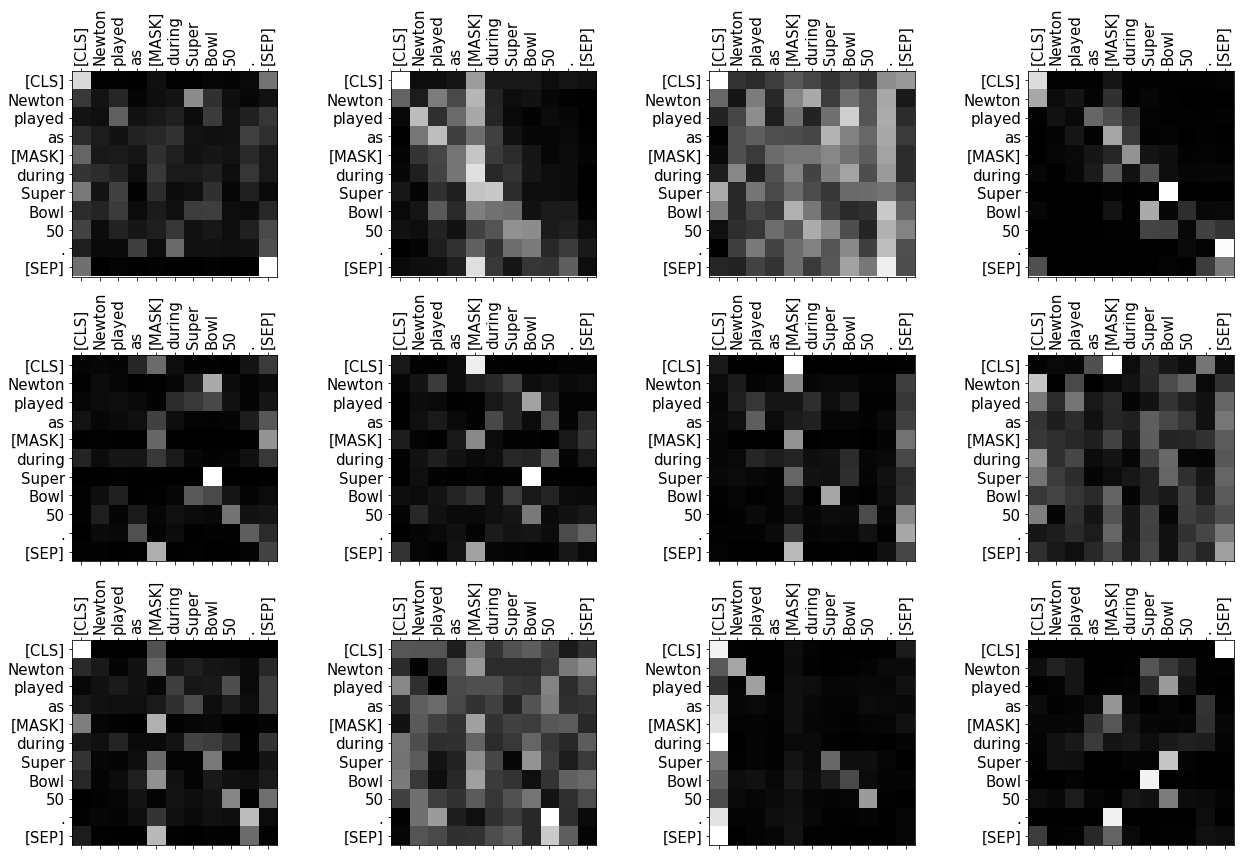

In [47]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

correct = [r for r in results if r['correct@1']]
wrong = [r for r in results if not r['correct@1']]

def show(idx=0, attn_layer=0, is_correct=True):
    result = correct[idx] if is_correct else wrong[idx]

    top_str = '\n\t'.join([('\t%s\t(%.4f)' % (t, p)) for t, p in zip(result['top_tokens'], result['top_probs'])])
    print("""%s
    \tlabel:\t%s

    \ttop:%s
    """ % (result['sentence'], result['label'], top_str))

    print("Attention weights (12 heads) from layer %d:" % attn_layer)
    # --- visualize attention
    fig, axs = plt.subplots(3, 4, figsize=(18, 12))

    toks = ['[CLS]'] + tokenizer.tokenize(result['sentence']) + ['[SEP]']
    for i, ax in enumerate(axs.reshape(-1)):
        ax.matshow(result['attn'][attn_layer][0][i].data.cpu().numpy(), cmap='gray')

        ax.set_xticks(range(len(toks)))
        ax.set_xticklabels(toks, rotation=90, fontsize=15)
        ax.set_yticks(range(len(toks)))
        ax.set_yticklabels(toks, fontsize=15)
    plt.tight_layout()
    
interactive(show, idx=(0, min(len(correct), len(wrong))-1), attn_layer=range(12), is_correct=True)